<a href="https://colab.research.google.com/github/YangchenHuang/Algorithmic_Trading/blob/master/RL_Evolution%20Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install bayesian-optimization

In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization

In [22]:
!rm -rf Algorithmic_Trading
!git clone https://github.com/YangchenHuang/Algorithmic_Trading

Cloning into 'Algorithmic_Trading'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [28]:
df = pd.read_csv('./Algorithmic_Trading/dataset/APPL.csv')
df.head()

,PERMNO,date,VOL,NUMTRD,PRC,OPENPRC
0,14593,1/3/2007,44545733,190644,11.971429,12.327143
1,14593,1/4/2007,34097551,136710,12.237143,12.007143
2,14593,1/5/2007,29842335,141427,12.150000,12.252857
3,14593,1/8/2007,28490191,130908,12.210000,12.280000
4,14593,1/9/2007,119827814,569923,13.224286,12.350000


In [0]:
data = df[['PRC', 'VOL', 'OPENPRC', 'NUMTRD']].to_numpy().flatten()
data = data.tolist()
close = df['PRC'].tolist()
window_size = 30
skip = 5
l = len(close) - 1
test_size=l//4
dev_size=0

In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d*4 : (t + 1)*4] if d >= 0 else -d * [data[0], data[1], data[2], data[3]] + data[0 : (t + 1)*4]
    res = []
    for i in range(n - 1):
        for j in range(4):
            if block[i*4+j]==0:
                res.append(0)
            else:
                res.append((block[(i + 1)*4+j] - block[i*4+j])/block[i*4+j])
    return np.array([res])

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate, validate, buy, model
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.fsigma = sigma
        self.validate = validate
        self.buy = buy
        self.model=model

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        reward_list=[]
        max_validate=0
        best_model=self.model
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            # for k in range(self.population_size):
            #     if rewards[k]>0:
            #         self.siglist[k] = np.clip(self.sigma*(rmax-rewards[k])/rran, 0.00001*self.sigma, self.sigma)
            #     if rewards[k]<=0:
            #         self.siglist[k]=self.sigma
            # print(self.siglist)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    * np.dot(A.T, rewards).T
                )
            final_reward=self.reward_function(self.weights)
            if i>0:
                if final_reward>max(reward_list):
                    self.sigma=self.sigma*np.clip((final_reward-max(reward_list))/(final_reward+1e-10),0.95, 0.999)
                if final_reward<np.average(reward_list):
                    self.sigma=min(self.sigma*np.clip(np.average(reward_list)/(np.average(reward_list)-final_reward+1e-10),1.001, 1.05),min(2*self.fsigma, 0.99))
                # if final_reward<reward_list[i-1]:
                #     self.sigma=np.clip(self.sigma*(reward_list[i-1])/(final_reward-reward_list))
            reward_list.append(final_reward)
            # v=self.validate()
            # if (i + 1) % print_every == 0:
            #     print(
            #         'iter %d. reward: %f validate: %f %%'
            #         % (i + 1, final_reward, v)
            #     )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, final_reward)
                )
                self.buy()
            # if v > max_validate:
            #     best_model.set_weights=self.weights
            if i==epoch-1:
                self.buy()
            
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size)*0.01,
            np.random.randn(layer_size, output_size)*0.01,
            np.random.randn(layer_size+1, 1)*0.01,
            np.zeros((1, layer_size)),
            np.zeros((1, output_size)),
            np.zeros((1,1))
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-3]
        a1=np.tanh(feed)
        decision = np.dot(a1, self.weights[1]) + self.weights[-2]
        z = np.append(np.argmax(decision[0]), a1)
        trade = np.dot(z, self.weights[2]) + self.weights[-1]
        return decision, trade

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
            self.validate,
            self.buy,
            self.model
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(data, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        # final_money = starting_money
        for t in range(30, l-test_size-dev_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money

            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size-dev_size-1]
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def validate(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(l-dev_size-test_size, l-test_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size]
        return ((initial_money - starting_money) / starting_money) * 100


    def buy(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        # final_money = starting_money
        for t in range(l-test_size, l, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money
                states_sell.append(t)
                print(
                    'day %d, sell %d units at price %f, total balance %f,'
                    % (t, sell_units, total_sell, initial_money)
                )
            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-1]
        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [0]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size*4, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        100000,
        skip,
        window_size,
    )
    agent.fit(5, 5)
    return agent.es.reward_function(agent.es.weights)

In [0]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size))*4,
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [0]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (7, 90),
        'skip': (1, 7),
        'population_size': (1, 150),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 308, 'skip': 6, 'population_size': 135, 'sigma': 0.5005567900865452, 'learning_rate': 0.2327320663695231, 'size_network': 657}


KeyboardInterrupt: ignored

iter 5. reward: 108.773495
day 2265: buy 3 units at price 315.780000, total balance 99684.220000
day 2266: buy 1 units at price 105.350000, total balance 99578.870000
day 2267: buy 5 units at price 513.550000, total balance 99065.320000
day 2268: buy 1 units at price 100.700000, total balance 98964.620000
day 2269: buy 1 units at price 96.450000, total balance 98868.170000
day 2273: buy 1 units at price 97.390000, total balance 98770.780000
day 2276: buy 1 units at price 96.660000, total balance 98674.120000
day 2277: buy 2 units at price 193.580000, total balance 98480.540000
day 2278: buy 5 units at price 481.500000, total balance 97999.040000
day 2279: buy 1 units at price 101.420000, total balance 97897.620000
day 2281: buy 9 units at price 899.910000, total balance 96997.710000
day 2282: buy 4 units at price 373.680000, total balance 96624.030000
day 2286: buy 13 units at price 1228.240000, total balance 95395.790000
day 2289: buy 8 units at price 752.160000, total balance 94643.6

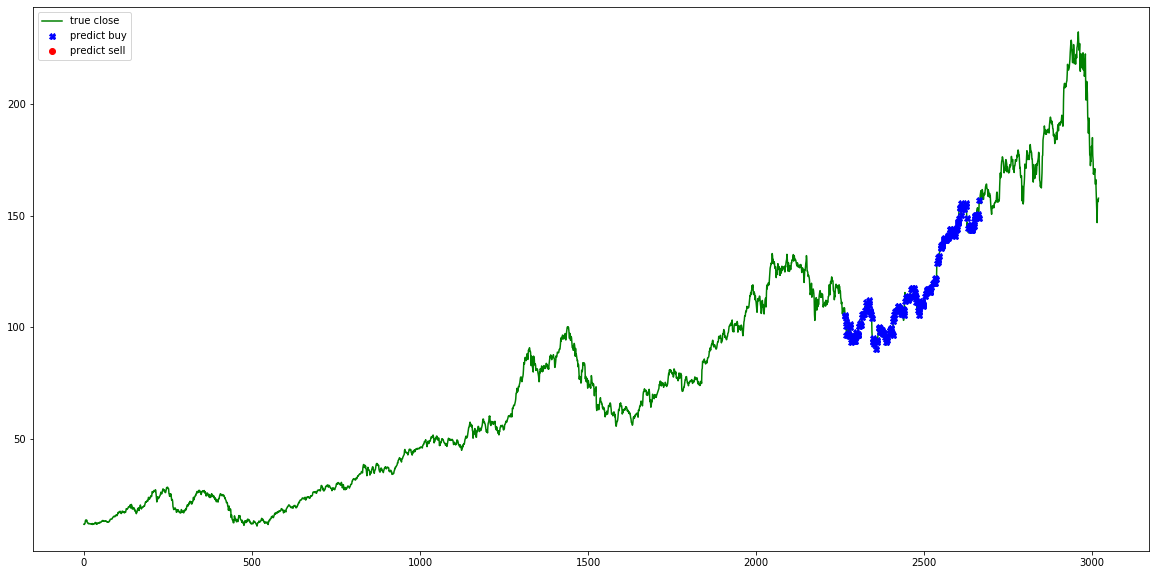

iter 10. reward: 73.032289
day 2265: buy 7 units at price 736.820000, total balance 99263.180000
day 2266: buy 1 units at price 105.350000, total balance 99157.830000
day 2267: buy 1 units at price 102.710000, total balance 99055.120000
day 2268: buy 20 units at price 2014.000000, total balance 97041.120000
day 2269: buy 1 units at price 96.450000, total balance 96944.670000
day 2272: buy 22 units at price 2199.120000, total balance 94745.550000
day 2273: buy 1 units at price 97.390000, total balance 94648.160000
day 2275: buy 20 units at price 1942.600000, total balance 92705.560000
day 2276: buy 1 units at price 96.660000, total balance 92608.900000
day 2277: buy 3 units at price 290.370000, total balance 92318.530000
day 2278: buy 7 units at price 674.100000, total balance 91644.430000
day 2282: buy 8 units at price 747.360000, total balance 90897.070000
day 2284: buy 16 units at price 1557.440000, total balance 89339.630000
day 2285: buy 1 units at price 96.430000, total balance 89

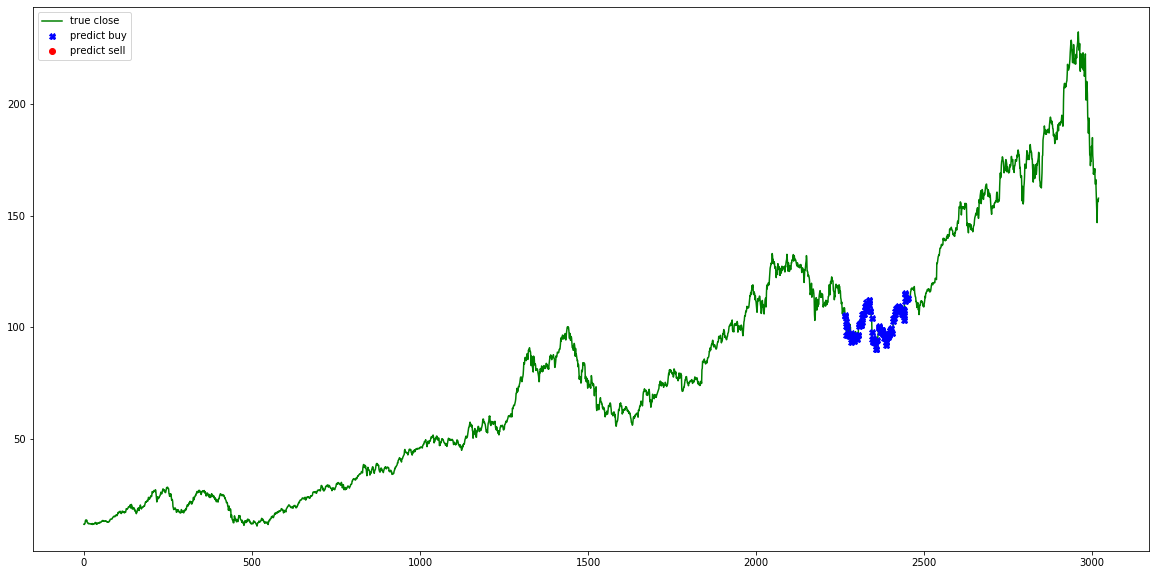

iter 15. reward: 283.560062
day 2265: buy 13 units at price 1368.380000, total balance 98631.620000
day 2266: buy 1 units at price 105.350000, total balance 98526.270000
day 2268: buy 21 units at price 2114.700000, total balance 96411.570000
day 2269: buy 1 units at price 96.450000, total balance 96315.120000
day 2272: buy 20 units at price 1999.200000, total balance 94315.920000
day 2273: buy 22 units at price 2142.580000, total balance 92173.340000
day 2275: buy 15 units at price 1456.950000, total balance 90716.390000
day 2276: buy 1 units at price 96.660000, total balance 90619.730000
day 2277: buy 22 units at price 2129.380000, total balance 88490.350000
day 2278: buy 8 units at price 770.400000, total balance 87719.950000
day 2282: buy 11 units at price 1027.620000, total balance 86692.330000
day 2284: buy 27 units at price 2628.180000, total balance 84064.150000
day 2285: buy 1 units at price 96.430000, total balance 83967.720000
day 2286: buy 24 units at price 2267.520000, tota

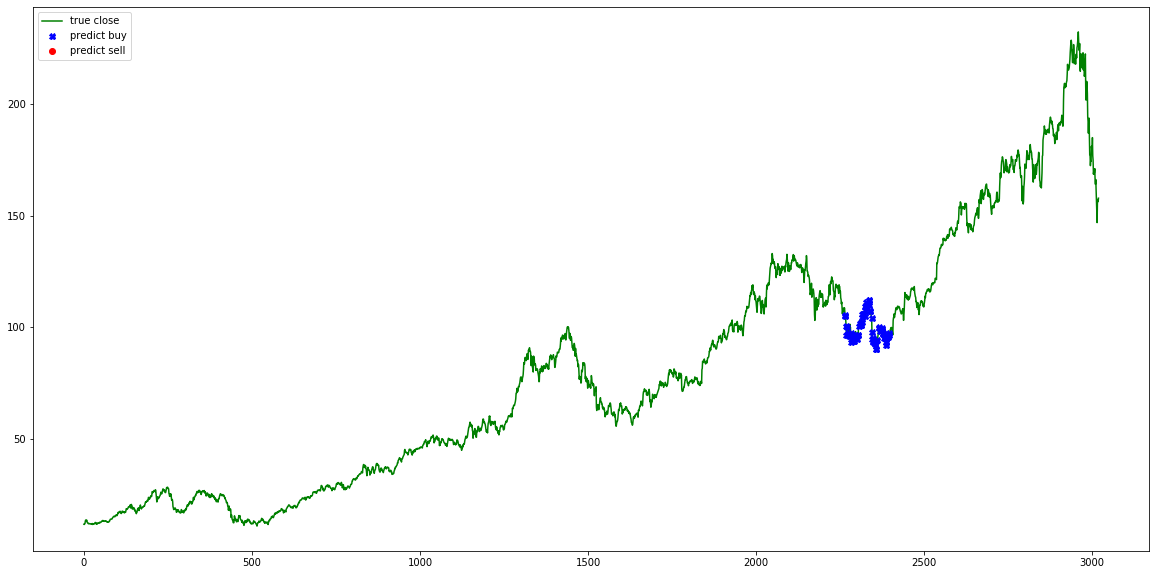

iter 20. reward: 309.726908
day 2265: buy 16 units at price 1684.160000, total balance 98315.840000
day 2266: buy 1 units at price 105.350000, total balance 98210.490000
day 2267: buy 11 units at price 1129.810000, total balance 97080.680000
day 2268: buy 29 units at price 2920.300000, total balance 94160.380000
day 2269: buy 1 units at price 96.450000, total balance 94063.930000
day 2272: buy 23 units at price 2299.080000, total balance 91764.850000
day 2273: buy 13 units at price 1266.070000, total balance 90498.780000
day 2275: buy 14 units at price 1359.820000, total balance 89138.960000
day 2276: buy 7 units at price 676.620000, total balance 88462.340000
day 2277: buy 22 units at price 2129.380000, total balance 86332.960000
day 2279: buy 25 units at price 2535.500000, total balance 83797.460000
day 2282: buy 3 units at price 280.260000, total balance 83517.200000
day 2283: buy 2 units at price 188.180000, total balance 83329.020000
day 2285: buy 2 units at price 192.860000, tota

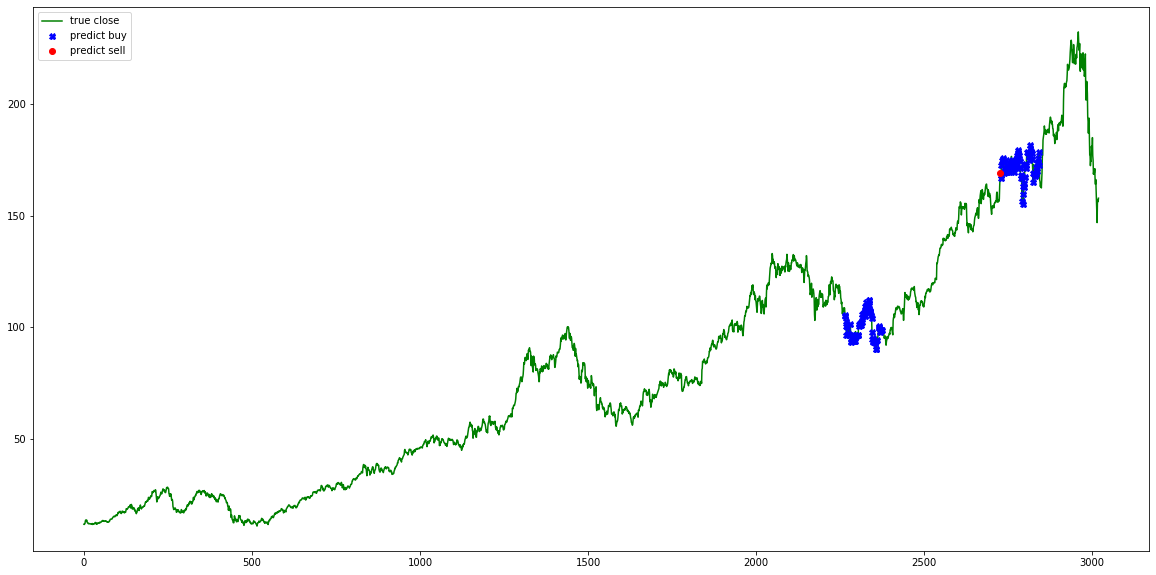

iter 25. reward: 364.207564
day 2265: buy 19 units at price 1999.940000, total balance 98000.060000
day 2266: buy 1 units at price 105.350000, total balance 97894.710000
day 2267: buy 18 units at price 1848.780000, total balance 96045.930000
day 2268: buy 32 units at price 3222.400000, total balance 92823.530000
day 2269: buy 1 units at price 96.450000, total balance 92727.080000
day 2270: buy 10 units at price 969.600000, total balance 91757.480000
day 2271: buy 20 units at price 1970.600000, total balance 89786.880000
day 2272: buy 26 units at price 2598.960000, total balance 87187.920000
day 2273: buy 12 units at price 1168.680000, total balance 86019.240000
day 2275: buy 29 units at price 2816.770000, total balance 83202.470000
day 2278: buy 3 units at price 288.900000, total balance 82913.570000
day 2280: buy 16 units at price 1591.040000, total balance 81322.530000
day 2282: buy 13 units at price 1214.460000, total balance 80108.070000
day 2283: buy 1 units at price 94.090000, to

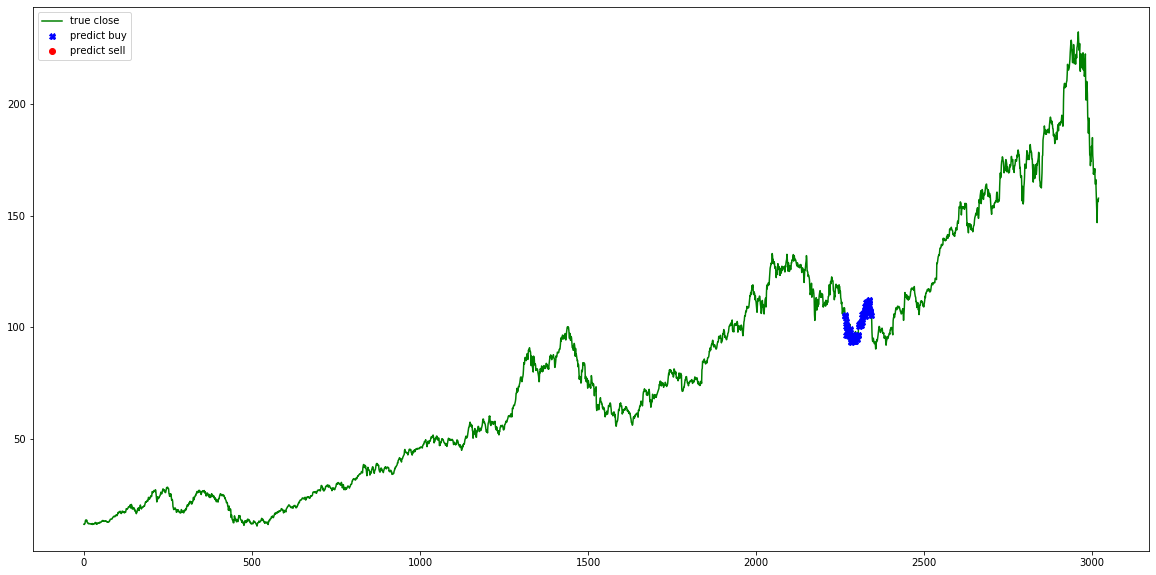

In [0]:
model = Model(input_size = 30*4, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 50, 
              sigma = 0.1, 
              learning_rate = 0.02, 
              model = model, 
              money = 100000,  
              skip = 1, 
              window_size = 30)
agent.fit(50, 5)

In [0]:
model = Model(input_size = int(np.around(NN_BAYESIAN.max['params']['window_size']))*4, 
              layer_size = int(np.around(NN_BAYESIAN.max['params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
              sigma = NN_BAYESIAN.max['params']['sigma'], 
              learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
              model = model, 
              money = 100000, 
              skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])))
agent.fit(500, 100)